##### Feature Analysis Plan

1. Load the processed data

    Load the CSV you just saved from data/processed/ so you're working with the fully featured DataFrame.                                                                                                               

2. Target distribution                                                                                                                                                                                              

    Check the split of your target — how many up days vs down days? If it's roughly 50/50, that's good. If it's heavily skewed (like 70/30), you'll need to account for that when modeling.                             

3. Feature vs target comparisons

    For each feature, ask: does this feature look different on up days vs down days?

    - Group by Target, then look at the mean of each feature. E.g., average RSI on up days vs down days. If they're noticeably different, that feature might have signal.
    - Histograms/box plots — for key features (RSI, MACD, Volume Ratio, Daily Return, Price Relative to MA), plot the distribution split by Target=0 vs Target=1. If the distributions overlap almost completely, the feature is weak. If they separate, it has potential.

4. Correlation heatmap
  
  - Compute the correlation between all your features and the Target. This gives you a quick ranking of which features have the strongest linear relationship with direction. Also check correlation between features themselves — highly correlated features (like MA_20 and Price_Relative_to_MA_20) are redundant, and you may want to drop one.

5. Write down observations

  Note which features look promising and which look like noise. This will guide which features you keep when you train your first model.ß

In [25]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
appl_df_features = pd.read_csv('../data/processed/AAPL_with_features.csv', parse_dates=['Date'])

In [26]:
# Target Distribution

# set target
target = appl_df_features['Target']

# calculate the frequencies
target_counts = target.value_counts()
up_dayes = target_counts.get(1, 0)
down_dayes = target_counts.get(0, 0)

# calculate percentages
up_percentae = (up_dayes / len(target)) * 100
down_percentae = (down_dayes / len(target)) * 100

print(f"Up days: {up_dayes} ({up_percentae:.2f}%)")
print(f"Down days: {down_dayes} ({down_percentae:.2f}%)")

# logic for handling skew
if up_percentae > 60 or down_percentae > 60:
    print("The target variable is skewed. Consider techniques like resampling or using different evaluation metrics.")
else: 
    print("The target variable is relatively balanced.")

Up days: 267 (55.86%)
Down days: 211 (44.14%)
The target variable is relatively balanced.


In [27]:
# Feautre vs Target Analysis
features_to_analyze = ["RSI_14", "MACD", "Volume_Ratio_20", "Daily_Return", "Price_Relative_to_MA_20", "Price_Relative_to_MA_50", "Signal_Line", "Middle_Band_20", "Upper_Band_20", "Lower_Band_20", "OBV"]

# Statistical summary (Grouped by Target)
print("\nStatistical Summary by Target:")
for feature in features_to_analyze:
    mean_up = appl_df_features[appl_df_features['Target'] == 1][feature].mean()
    mean_down = appl_df_features[appl_df_features['Target'] == 0][feature].mean()
    diff = mean_up - mean_down
    print(f"{feature}: Mean Up Days = {mean_up:.6f}, Mean Down Days = {mean_down:.6f}, Difference = {diff:.6f}")


Statistical Summary by Target:
RSI_14: Mean Up Days = 54.393032, Mean Down Days = 54.310936, Difference = 0.082097
MACD: Mean Up Days = 1.152812, Mean Down Days = 1.271287, Difference = -0.118475
Volume_Ratio_20: Mean Up Days = 0.990325, Mean Down Days = 1.025521, Difference = -0.035195
Daily_Return: Mean Up Days = 0.001866, Mean Down Days = 0.000282, Difference = 0.001584
Price_Relative_to_MA_20: Mean Up Days = 0.008367, Mean Down Days = 0.008789, Difference = -0.000422
Price_Relative_to_MA_50: Mean Up Days = 0.021352, Mean Down Days = 0.019982, Difference = 0.001369
Signal_Line: Mean Up Days = 1.172529, Mean Down Days = 1.205453, Difference = -0.032924
Middle_Band_20: Mean Up Days = 220.792643, Mean Down Days = 225.124253, Difference = -4.331610
Upper_Band_20: Mean Up Days = 233.524318, Mean Down Days = 237.746105, Difference = -4.221787
Lower_Band_20: Mean Up Days = 208.060968, Mean Down Days = 212.502402, Difference = -4.441434
OBV: Mean Up Days = 728885891.385768, Mean Down Days 

# Observation

This doesn't look so good. Right now, it seems that the current features have almost ZERO predictive power for the target. This means my feautres are "noisy". I mean yeah, this is normal because if individual features could cleanly separate up days from down days then everyone would be rich. Somehting to understand is stock prediction is inherently noisy. A feature with even a 1-2% edge over random is useful when combined with other features in a model. Right now i'm not looking for features that scream "BUY", just looking for features that nudge the probability slightly

### Why these numbers are red flags:

The "Noise" Problem    
- RSI_14 (Diff: 0.08): From what I can tell, an RSI difference of 0.08 on a scale of 0 to 100 is negligible. It means the "momentum" is identical regardless of whether the day ends green or red.
- MACD (Diff: -0.12): This is slightly more active than the others, but still statistically insignificant. Interestingly, the MACD is actually higher on down days (1.27 vs 1.15), which is counter-intuitive.
- Daily Return (Diff: 0.00): This is the biggest warning sign. If the average return on an "Up Day" is 0.00, it suggests your target might be miscalculated or your data lacks enough decimal precision.

RSI_14 has an overlap of 56.39 between Up and Down days, indicating it may not be a strong discriminator.


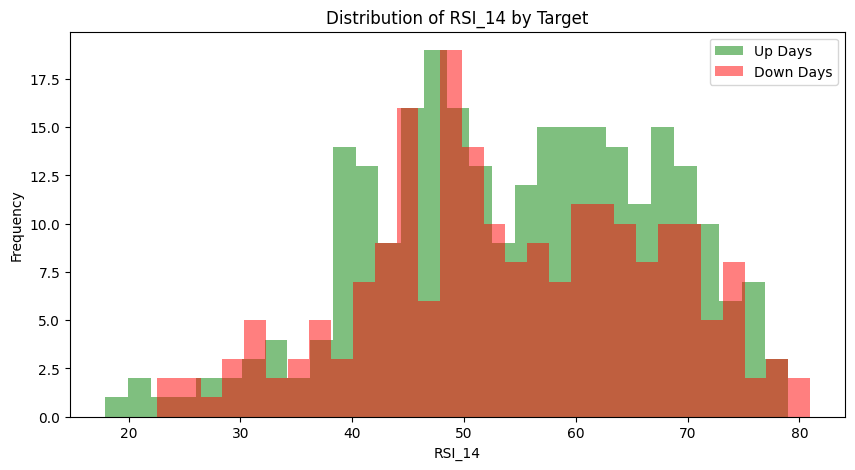

MACD has an overlap of 18.94 between Up and Down days, indicating it may not be a strong discriminator.


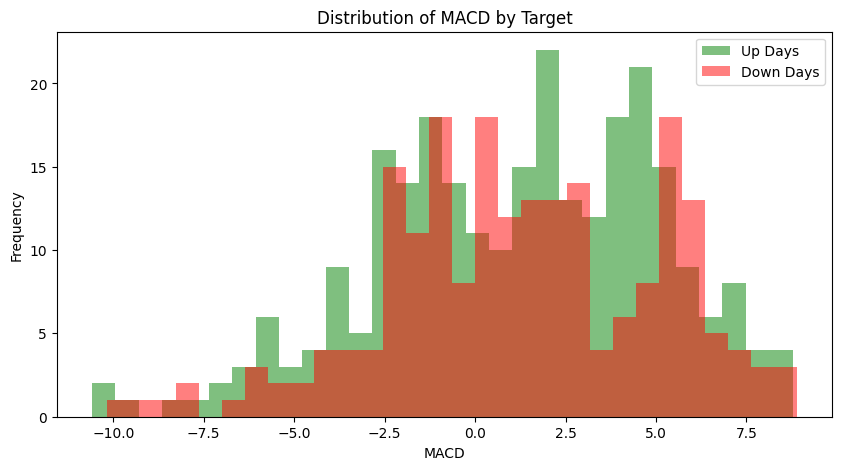

Volume_Ratio_20 has an overlap of 2.59 between Up and Down days, indicating it may not be a strong discriminator.


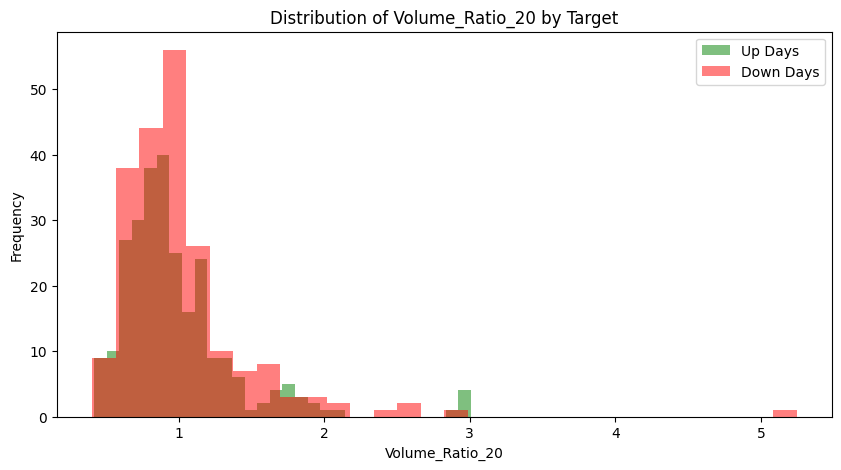

Daily_Return has an overlap of 0.12 between Up and Down days, indicating it may not be a strong discriminator.


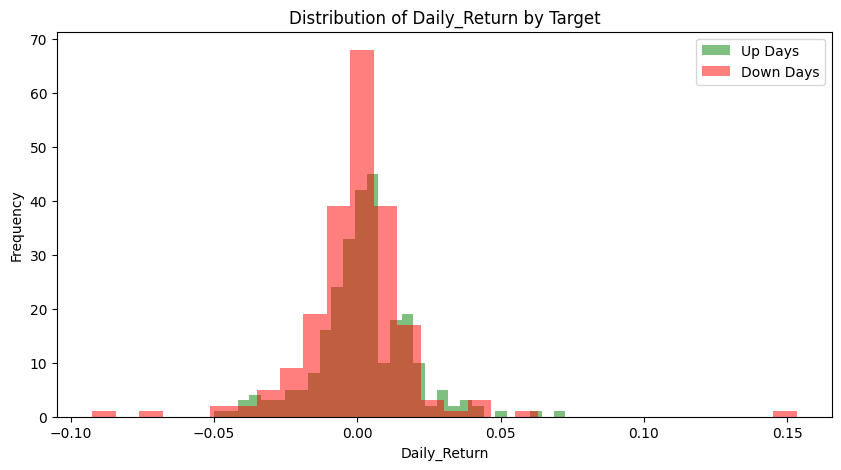

Price_Relative_to_MA_20 has an overlap of 0.25 between Up and Down days, indicating it may not be a strong discriminator.


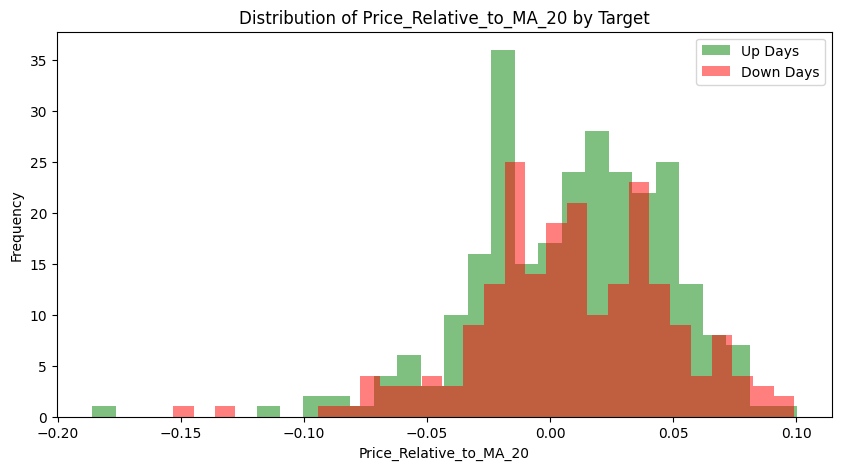

Price_Relative_to_MA_50 has an overlap of 0.38 between Up and Down days, indicating it may not be a strong discriminator.


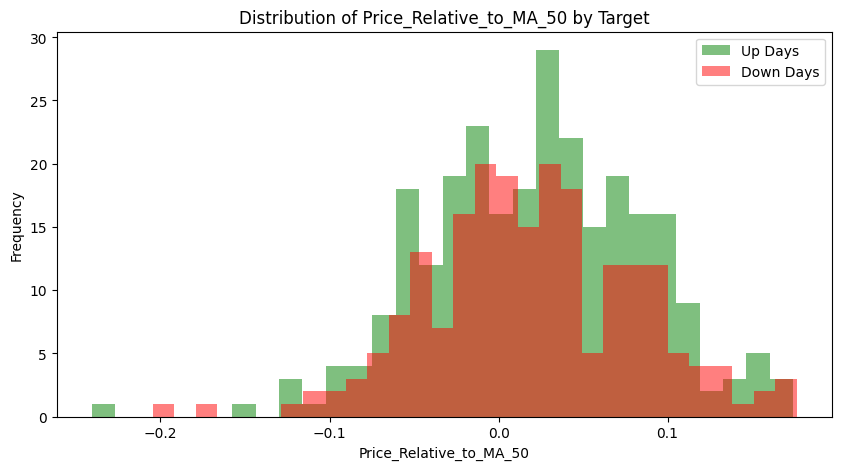

Signal_Line has an overlap of 16.36 between Up and Down days, indicating it may not be a strong discriminator.


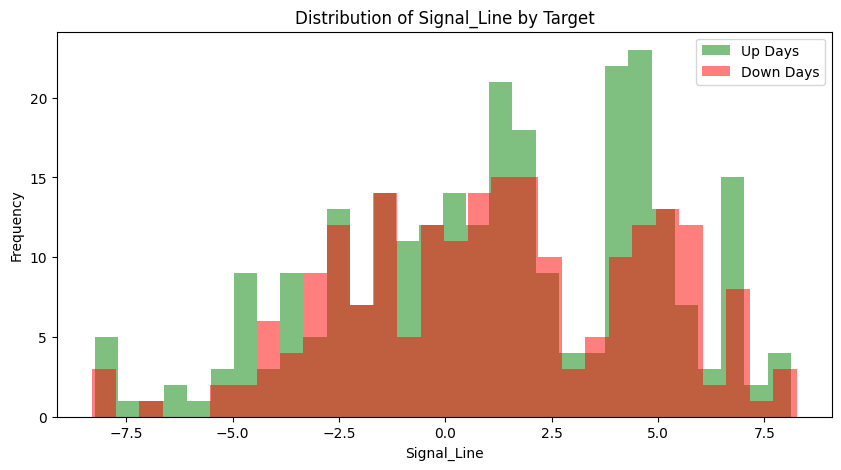

Middle_Band_20 has an overlap of 109.27 between Up and Down days, indicating it may not be a strong discriminator.


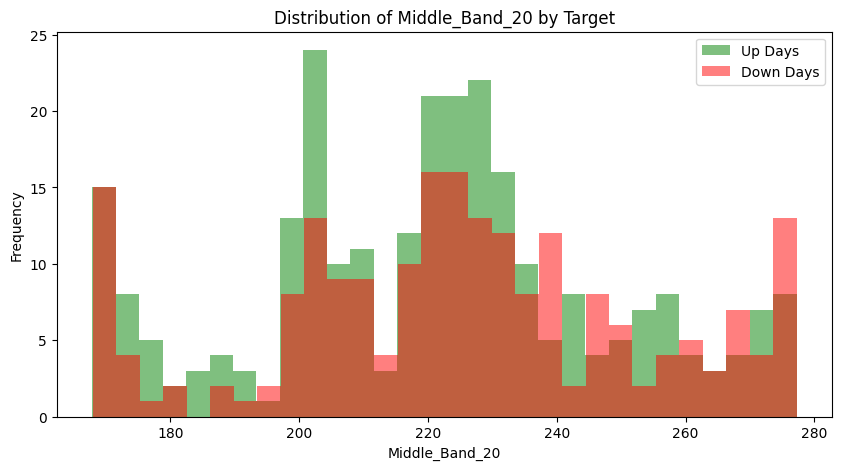

Upper_Band_20 has an overlap of 113.87 between Up and Down days, indicating it may not be a strong discriminator.


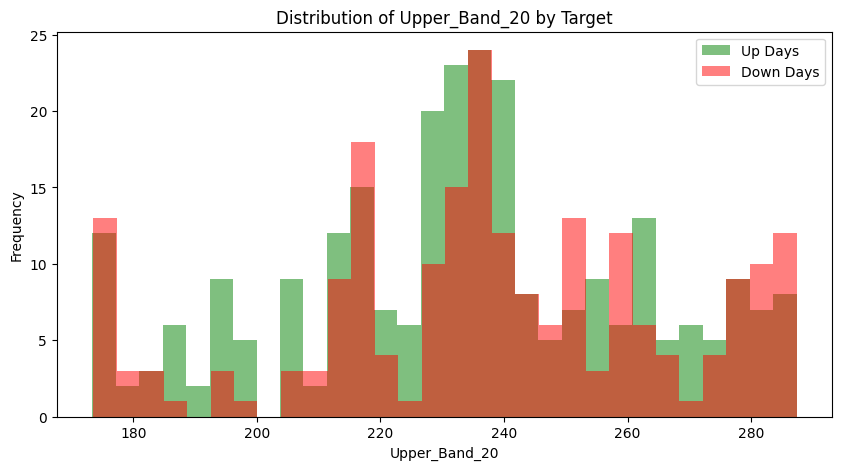

Lower_Band_20 has an overlap of 110.58 between Up and Down days, indicating it may not be a strong discriminator.


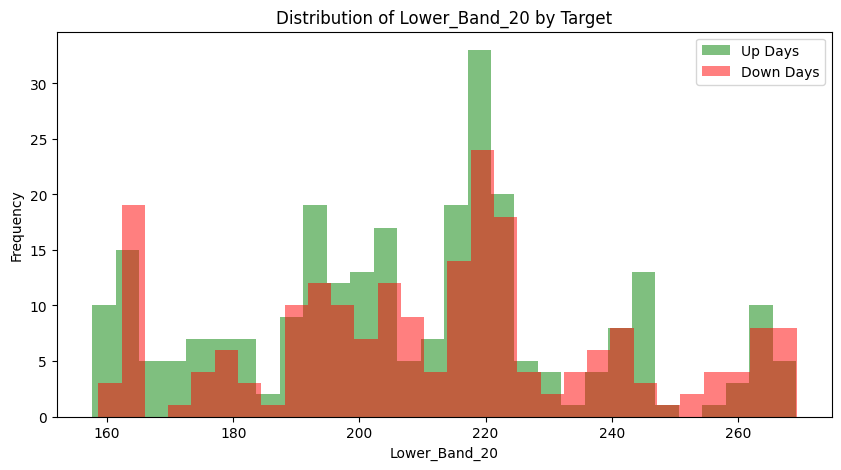

OBV has an overlap of 2896103500.00 between Up and Down days, indicating it may not be a strong discriminator.


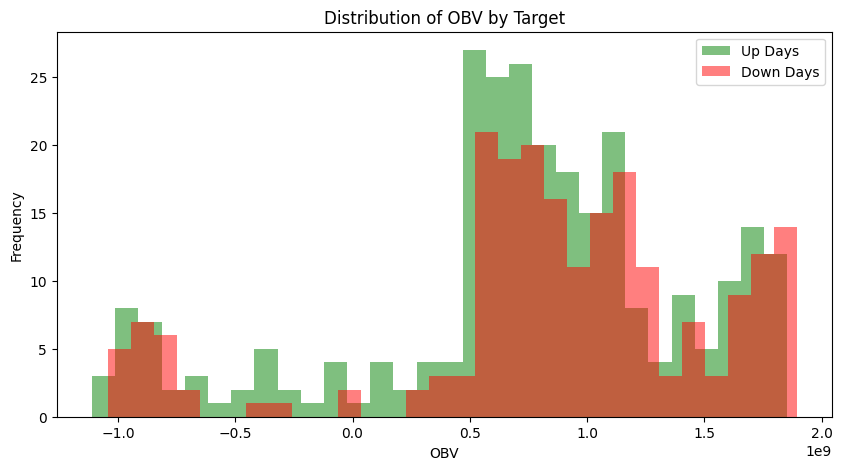

In [28]:
# Visual Distribution Comparison (Histogram Logic)
for feature in features_to_analyze:
    plt.figure(figsize=(10, 5))
    plt.hist(appl_df_features[appl_df_features['Target'] == 1][feature], bins=30, alpha=0.5, label='Up Days', color='green')
    plt.hist(appl_df_features[appl_df_features['Target'] == 0][feature], bins=30, alpha=0.5, label='Down Days', color='red')

    overlap = min(appl_df_features[appl_df_features['Target'] == 1][feature].max(), appl_df_features[appl_df_features['Target'] == 0][feature].max()) - max(appl_df_features[appl_df_features['Target'] == 1][feature].min(), appl_df_features[appl_df_features['Target'] == 0][feature].min())
    if overlap > 0:
        print(f"{feature} has an overlap of {overlap:.2f} between Up and Down days, indicating it may not be a strong discriminator.")
    else:
        print(f"{feature} has no overlap between Up and Down days, indicating it may be a strong discriminator.")

    plt.title(f'Distribution of {feature} by Target')
    plt.xlabel(feature)
    plt.ylabel('Frequency')
    plt.legend()
    plt.show()

# Observation:

Yup, confirms exactly what the numbers were suggesting: the distributions are nearly identical. From my understanding, in the world of machine learning, this is called feature overlap, and it’s a clear sign that the model will struggle to find a pattern.

**The Problem:** Predictive Paralysis
- **The "Brown" Zones:** Most of the bars are brown. This is the red and green histograms overlapping 90-95% of the time. This tells the model: "An RSI of 50 is just as likely to lead to a Down Day as an Up Day."
- **The Daily Return Chart:** The fact that the distributions for both "Up" and "Down" days are centered almost perfectly at 0.00 confirms that the features don't shift the probability of the outcome at all.

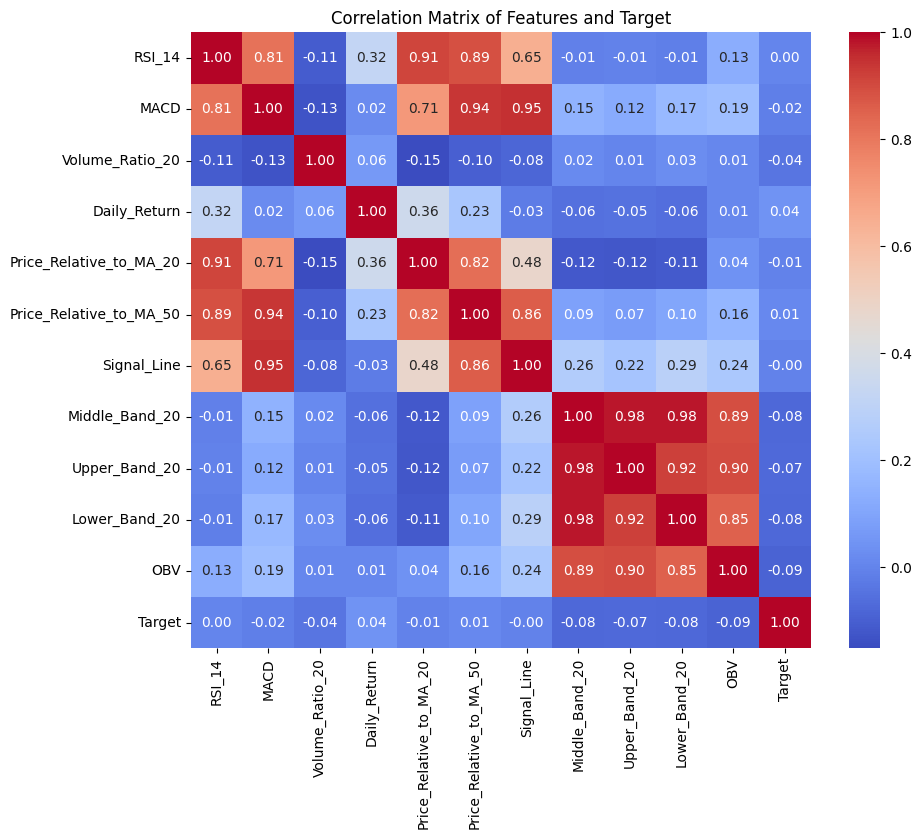

In [29]:
# Correlation heatmap
correlation_matrix = appl_df_features[features_to_analyze + ['Target']].corr()
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix of Features and Target')
plt.show()

# Observation
**Daily Return:** now that we're printing with 6 decimals, we can see there is a difference (0.001866 vs 0.000282). It's small, but it exists.


**Bollinger Bands (Middle, Upper, Lower)** — the ~$4 difference between up and down days is kinda misleading. That's not a predictive signal, it's just reflecting that AAPL's price was higher later in the dataset (general uptrend). These raw dollar values are price-dependent, so they don't generalize. What would be useful instead is where price sits within the bands — something like (Close - Lower_Band) / (Upper_Band - Lower_Band). That would give me a 0-to-1 value representing position within the bands, normalized and comparable regardless of price level.

**OBV** — same problem as the Bollinger Band raw values. OBV is a cumulative number that keeps growing, so comparing means between up/down days isn't meaningful. What's more useful is the rate of change of OBV (e.g., OBV today vs OBV 5 days ago).             

**Signal Line** — highly correlated with MACD (since it's derived from it). I can probably keep just one, or use the difference between them (MACD - Signal Line, often called the "MACD histogram") as a single feature instead.

**Some Takeaways:**
  - Drop raw Bollinger Band values and raw OBV from your model features
  - Add Bollinger Band position (normalized) and OBV rate of change to features
  - Update the signla feautre to be MACD minus Signal Line instead of both separately
  - The original features (RSI, MACD, Volume Ratio, Daily Return, Price Relative to MA) are still my best candidates


## Note:
We will not remove any features from feature_engineering.py but instead add 2 new features:
1. Bollinger Band position (normalized)
2. OBV rate of change
We will also update the signal feature to be MACD - Signal Line

When I build my model, I'll select which columns to use as input features. At that point, I won't include the raw Bollinger Band values, raw OBV, or raw MA columns in the feature list. I'll pick the useful ones (RSI, MACD, Volume Ratio, Daily Return, Price Relative to MA, etc.) and leave the rest out.

**Way to think of it:** feature_engineering.py is the kitchen — I prep everything there. But I don't put every ingredient on the plate.

After talking with Claude, it told me all this is normal and I can move on to modeling so it can help tell me what's useful.